# Relevant Packages

In [1]:
#Import packages
import IPython.display as ipd
import numpy as np
import pyaudio, wave
import math
import matplotlib.pyplot as plt
from numpy.matlib import repmat
from scipy.fftpack import dct

In [2]:
#pip install  keyboard

In [3]:
def bark2hz(z):
    #Converts frequencies Bark to Hertz (Hz)
    hz = 600 * np.sinh(z/6);
    return hz

In [4]:
def hz2bark(f):
    #Converts frequencies Hertz (Hz) to Bark
    # Inverse of Hynek's formula (see bark2hz)
    z = 6 * np.arcsinh(f/600);
    return z

# Flow：

1. Pre-Emphasize the whole chunk
2. Windowing to get the frames
3. Zero padding to prepare for the Fast Fourier Transform (FFT)
4. Fast Fourier Transform to get the power spectrum
5. Filter bank
6. Take logarithm to get the Log Mel spectrum
7. Discrete Cosine Transform (DCT)
8. Get the MFCC

# Functions

## Pre-Emphasizing a speech signal

The spectrum of the speech signal naturally has lower energy at higher frequencies. This spectral tilt can be
corrected by pre-emphasizing the signal. Here we apply a pre-emphasis filter to amplify the high frequencies. The filter we use is: $$S_ p[n] = S[n] – 0.95*S[n-1]$$

In [5]:
#Pre-emphasize the speech signal by a filter equation
def Preemphasizing(chunk):
    #input is the chunk with length set to 1600, it could also be the whole signal document (preferred)
    pe=np.zeros(len(chunk))
    pe[0]=chunk[0]
    for i in range(1,len(chunk)):
        pe[i]=chunk[i]-0.95*chunk[i-1]
    return pe

## Windowing the speech signal

In [6]:
#Apply window function to the frames
def windowing(frame,mode="Hamming"):
    #do windowing for the signal frame
    n=len(frame)
    #windowing the speech signal
    if mode=="Hamming":
        frame=frame*np.hamming(n)
    elif mode=="Hanning":
        frame=frame*np.hanning(n)
    elif mode=="Blackman":
        frame=frame*np.blackman(n)
    return frame

## Zero padding the frames 

Prepare for the Fast-Fourier Transform (FFT).

In [7]:
#Pad zero to make the frame a desired length (exponential of 2)
def zero_padding(frame,FFT_size=512):
    #zero padding for FFT
    frame_length=len(frame)
    padding_length=FFT_size-frame_length
    zeros=np.zeros((padding_length,))
    zero_padding_frame=np.concatenate((frame,zeros))
    return zero_padding_frame

## Fast-Fourier Transform (FFT) 

Get the power spectrum.

In [8]:
#Fast-Fourier Transform
def FFT(frame,FFT_size=512):
    #http://dong.sh/posts/difffftandrfft/
    #we use the rfft rather than the fft, the difference is shown in the website above.
    # in short rfft give a result of half of the fft_size
    mag_frame = np.absolute(np.fft.rfft(frame, FFT_size))  # Magnitude of the FFT
    power_spectrum = ((1.0 / FFT_size) * ((mag_frame) ** 2))  # Power Spectrum
    return power_spectrum

##  Warping the frequency axis Hz 2 Mel & Mel 2 Hz

In [9]:
#Herz to Mel
def hz2mel(f):
    #  Convert frequencies f (in Hz) to mel 'scale'.
    #Mel warping function
    z = 2595 * np.log10(1+f/700);
    return z

In [10]:
#Mel to Herz
def mel2hz(z):
    # Convert 'mel scale' frequencies into Hz
    f = 700*(np.power(10,z/2595)-1)  #CHR use np.power to simulate ".^" in matlab
    return f

## Filter Bank

In [11]:
def filterbanks(power_spectrum,lower_boundHz=133.33,upper_boundHz=6855.4976,num_banks=40,FFT_size=512):
    upper_boundMel=hz2mel(upper_boundHz)
    lower_boundMel=hz2mel(lower_boundHz)
    #Uniformly sample in Mel scale to get 40 triangular filters
    mel_points=np.linspace(lower_boundMel,upper_boundMel,num_banks+2)
    #Transform to frequency scale and generate non-uniformly distributed triangular filters
    hz_points=mel2hz(mel_points)
    #After FFT, the sample become half of the original (integer)
    bin=np.floor((FFT_size + 1)/2*hz_points/(upper_boundHz-lower_boundHz))
    #Correspond the frequency points to the power spectrum after FFT
   #print(bin)
    #Normalization because of the lower bound
    bin=bin-bin[0]
    fbank=np.zeros((num_banks,int(np.floor(FFT_size/2+1))))
    for m in range(1,num_banks+1):
        f_m_low=int(bin[m-1])   # left
        f_m_center=int(bin[m])  # center
        f_m_up=int(bin[m+1])    # right
        for k in range(f_m_low,f_m_center):
            fbank[m-1,k]=(k-bin[m-1])/(bin[m]-bin[m-1])
        for k in range(f_m_center,f_m_up):
            fbank[m-1,k]=(bin[m+1]-k)/(bin[m+1]-bin[m])
    #Dot product
    Fb=np.dot(power_spectrum,fbank.T)
    #eps is a small float number. when Fb is 0, Fb is eps. this is to avoid error in division
    Fb=np.where(Fb==0,np.finfo(float).eps,Fb) # Numerical Stability
    
    #Log Mel spectrum
    #Compress values
    Log_Mel_spectrum=10*np.log(Fb) 
    
    return Log_Mel_spectrum

# MFCC PART

Here, I write three functions to get MFCC feature (39 dim) one is from project 2 another two functions are made of librosa and python_speech_features. 

In [1]:
def getMFCC(wavename):
    import numpy as np
    import scipy.io.wavfile as wav
    from python_speech_features import mfcc
    fs, audio = wav.read(wavename)
    Preemphasizeddata=Preemphasizing(audio) 
    newframes=rec._chunk2frames(Preemphasizeddata)
    #logmelspectrum
    logmelspectrum=[]
    mfcc=[]
    for frame in newframes:
        frame=windowing(frame)
        frame=zero_padding(frame)
        power_spectrum=FFT(frame)
        Log_Mel_spectrum=filterbanks(power_spectrum,num_banks=40)
        logmelspectrum.append(Log_Mel_spectrum)
        mfcc_40=dct(Log_Mel_spectrum, type=2, norm='ortho')[0 : 13] # Keep 2-13
        mfcc.append(mfcc_40)
    #Normalization
    mean=np.mean(mfccs,0)
    for i in range(len(mfccs)):
        for j in range(13):
            mfccs[i][j]=mfccs[i][j]-mean[j]

    mfccs[0]=np.hstack((mfccs[0],mfccs[0],mfccs[0]))
    mfccs[-1]=np.hstack((mfccs[-1],mfccs[-1],mfccs[-1]))

    for i in range(1,len(mfccs)-1):
        delta=np.zeros(13)
        for j in range(13):
            delta[j]=mfccs[i+1][j]-mfccs[i-1][j]
        mfccs[i]=np.hstack((mfccs[i],delta))

    for i in range(1,len(mfccs)-1):
        acc=np.zeros(13)
        for j in range(13):
            acc[j]=mfccs[i+1][13+j]-mfccs[i-1][13+j]
        mfccs[i]=np.hstack((mfccs[i],acc))

    std=np.std(mfccs)
    var=np.var(mfccs,1)
    for i in range(len(mfccs)):
        for j in range(39):
            mfccs[i][j]=mfccs[i][j]/var[i]

    return np.array(mfccs)    

In [2]:
def getMFCC2(wavename):#without normalization
    import numpy as np
    import scipy.io.wavfile as wav
    from python_speech_features import mfcc
    fs, audio = wav.read(wavename)
    feature_mfcc = mfcc(audio, samplerate=fs)
    mfcc=[]
    mfcc.append(np.hstack([feature_mfcc[0],feature_mfcc[0],feature_mfcc[0]]))
    for i in range(1,len(feature_mfcc)-1):
        delta=np.zeros(13)
        for j in range(13):
            delta[j]=feature_mfcc[i+1][j]-feature_mfcc[i-1][j]
        mfcc.append(np.hstack([feature_mfcc[i],delta]))
    mfcc.append(np.hstack([feature_mfcc[-1],feature_mfcc[-1],feature_mfcc[-1]]))

    for i in range(1,len(mfcc)-1):
        acc=np.zeros(13)
        for j in range(13):
            acc[j]=mfcc[i+1][13+j]-mfcc[i-1][13+j]
        mfcc[i]=np.hstack([mfcc[i],acc])
    mfccs=np.array(mfcc)
    std=np.std(mfccs)
    var=np.var(mfccs,1)
    for i in range(len(mfccs)):
        for j in range(39):
            mfccs[i][j]=mfccs[i][j]/var[i]
    return mfccs

In [3]:
def getMFCC3(wavename):#with normalization
    import librosa
    audio, sr = librosa.load(wavename,sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr,n_mfcc=39)
    std=np.std(mfccs)
    var=np.var(mfccs,1)
    for i in range(len(mfccs)):
        for j in range(39):
            mfccs[i][j]=mfccs[i][j]/var[i]
    return mfccs

# Create Templates


There are total 100 wave files, 10 samples for digit 1-10. All these files are saved in the following format by Huangrui Chu: digit_0.wav, digit_1.wav.  digit could be 0,1,2,...9.

In [11]:
def create_templates(foldername,start_instance,end_instance):
    #we could also use this function for project 1,2,3 for testing our algorithm
    #INPUT:
        #foldername: the name of folder where Huangrui save the audio files
        #end-start:the number of instance we are expected to use as the templates.
    #OUTPUT:
        #templates: we can easily fetch the template for the corresponding digit using:
                #len(templates)%10+digit
    templates=[]
    max_template_length=0
    for i_th_instance in range(start_instance,end_instance):
        for digit in range(0,10):
            #print(str(digit )+'_'+str(i_th_instance)+'.wav')
            mfcc=getMFCC2(foldername+"/"+str(digit )+'_'+str(i_th_instance)+'.wav')
            if max_template_length<len(mfcc):
                max_template_length=len(mfcc)
            templates.append(mfcc)
    return templates,max_template_length

# DTW(Dynamic Time Warping)

In [167]:
def dtw(template,data):
    #Author: Huangrui Chu
    #Input:
        #template 39 dim array
        #data 39 dim array
    import numpy as np
    # insert fin at the beginning of the template and data
    zeros=np.zeros([39])
    template=np.vstack([zeros,template])
    data=np.vstack([zeros,data])
    
    t=len(template) # means i th template frame aligns with j-th input frame
    d=len(data)#means input frame j
    #create empty best path cost matrix "P" 
    P=np.zeros([t])
    
    
    for j in range(d): #input frame j
        P1=np.zeros([t])
        for i in range(t): # i th template frame aligns with j-th input frame
            Cij=np.sqrt(np.sum(np.square(template[i]-data[j])))
            #print(Cij)
            if i-2>=0:
                P1[i]=min(P[i],P[i-1],P[i-2])+Cij
            elif i-1>=0:
                P1[i]=min(P[i],P[i-1])+Cij
            else:
                P1[i]=P[i]+Cij
        P=P1.copy() #Use deep copy to updata the best path cost
        #print(P)
    #Use DTW cost / frame of input speech, instead of total DTW cost, before determining threshold
    # 5 PPT  p.g 32
    normalized_cost=P[-1]/d
    return normalized_cost

# dtw-based recognition

In [158]:
def DTW_Based_recognition(templates,check_mfcc):
    smallest_distance=[100000,10000]
    #smallest_distance[0] save the current smallest distance,smallest_distance[1] save the corresponding template id
    for i in range(len(templates)):
        distance=dtw(templates[i],check_mfcc)
        if distance<smallest_distance[0]:
            smallest_distance[0]=distance
#             print(distance)
            smallest_distance[1]=i
#             print("id is {}".format(i))
#             print("maybe {}".format(i%10))
    final_answer=smallest_distance[1]%10
#     print("I guess the answer is {}".format(final_answer))
    return final_answer

In [159]:
foldername="../data"
test_data,max_test_length=create_templates(foldername,5,10)
templates,max_template_length=create_templates(foldername,0,1)

NameError: name 'mfccs' is not defined

In [160]:
check_mfcc=test_data[6]

NameError: name 'test_data' is not defined

In [161]:
DTW_Based_recognition(templates,check_mfcc)

NameError: name 'templates' is not defined

# Time Synchronous Search DTW

In [162]:
def TS_DTW_Based_recognition(templates,max_template_length,data,threshold=0.1):
    #Author: Huangrui Chu
    #Input:
        #templates a list containing several 39 dim arrays
        #data 39 dim array
        #threshold: the threshold to stop the search for certain template
                    #the threshold should be soft 想想教授上课怎么讲的，我忘了
    import numpy as np
    num_templates=len(templates)
    #the templates that are still candidates
    to_test_templates=np.zeros([num_templates])+1
    to_test_templates_length=np.zeros([num_templates])
    # insert fin at the beginning of the template and data
    template=templates[0]
    zeros=np.zeros([39])
    TS_template=np.vstack([zeros,template])
    to_test_templates_length[0]=len(template)
    for i in range(1,num_templates):
        template=templates[i]
        zeros=np.zeros([39])
        template=np.vstack([zeros,template])
        to_test_templates_length[i]=len(template)
        #pad all the templates to the same length
        TS_template=np.hstack([TS_template,template])
    print(TS_template.shape)
    data=np.vstack([zeros,data])
    
    t=len(template) # means i th template frame aligns with j-th input frame
    d=len(data)#means input frame j
    #create empty best path cost matrix "P" 
    P=np.zeros([t])

In [89]:
TS_DTW_Based_recognition(templates,max_template_length,check_mfcc,threshold=0.1)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 270 and the array at index 1 has size 250

# check the accuracy

In [96]:
def check_the_accuracy(foldername,start_instance,end_instance,test_data):
    print("Huangrui is going to check the accuracy based dtw with {} templates".format(end_instance-start_instance))
    the_input_digit=[]
    the_dtw_result=[]
    templates=create_templates(foldername,start_instance,end_instance)
    for i in range(len(test_data)):
        current_digit=i%10
        current_guess=DTW_Based_recognition(templates,test_data[i])
        the_input_digit.append(current_digit)
        the_dtw_result.append( current_guess)
    return the_input_digit,the_dtw_result

In [97]:
foldername="../data"
test_data=create_templates(foldername,5,10)

In [ ]:
a,b= check_the_accuracy(foldername,0,1,test_data)

In [106]:
result=np.array(a)-np.array(b)
correct_num=np.sum(result==0)
test_num=len(result)
test_accuracy=correct_num/test_num
print("Among all the {} test instance, {} are corret, the accuracy is {}".format(test_num,correct_num,test_accuracy))

Among all the 50 test instance, 8 are corret, the accuracy is 0.16


# Problem 2 K Means Hard Version

Use the segmental K-means procedure to train an HMM for each of the digits
(using the 5 "training" recordings you have for them). Assume each state to
have a single Gaussian distribution, and the HMM for each digit to have 5
states. Recognize the 5 test utterances using the HMM models and report
recognition accuracy.

In [4]:
 def traceback(D):
    #start from the last state and last frame
    current_state,current_frame=np.array(D.shape)-1
    #insert the last frame's state
    x=[current_state]
    
    #print(current_frame+1)
    # we do not need the frame 0, which is the fine
    while current_state>0 and current_frame>1:
        #move to the previous frame
        current_frame-=1
        #print(current_state)
        if current_state>2:
            to_check=[D[current_state][current_frame-1],
                      D[current_state-1][current_frame-1],
                      D[current_state-2][current_frame-1]]
            track=np.argmin(to_check)
        elif current_state>1:
            to_check=[D[current_state][current_frame-1],
                      D[current_state-1][current_frame-1]]
            track=np.argmin(to_check)
        else:
            track=0
            
        if track==0:
            #which means, last frame still in the same stage
            x.insert(0,current_state)
        elif track==1:
            current_state-=1
            x.insert(0,current_state)
        else:
            current_state-=2
            x.insert(0,current_state)
    #print(x)
    
#     print(len(x))
#    print(np.bincount(x, weights=None, minlength=0))
#     print()
    return x

In [ ]:
def log_gaussian(mu,squared_sigma,input_vector):
    #Author: Huangrui Chu, 
    #Calculate the cost using log gaussian
    part1=0.5*np.sum(np.log((2*np.pi)*(squared_sigma)))
    part2=0.5*np.sum(np.square((input_vector-mu))/squared_sigma)
    cost= part1+part2
    return cost

In [5]:
import numpy as np
def Kmean_dtw(model_vectors,data,T,cov_cent,get_track=False):
    #Author: Huangrui Chu
    #Input, T is the transition_score
    #yes, we use cost!!!!!!!!
    #Output: the path, how we align each node
    # insert fin at the beginning of the template and data
    zeros=np.zeros([39])
    model_vectors=np.vstack([zeros,model_vectors])
    #这边对应的是不是我的cov 要append1？？？???????????????????????????????????
    ones=np.zeros([39])+1
    cov_cent=np.vstack([ones,cov_cent])
    data=np.vstack([zeros,data])
    #print(data.shape)

    t=len(model_vectors) # here, t should be the number of states+1 we set
    d=len(data)#means input frame j
    #create empty best path cost matrix "P" 
    P=np.zeros([t,d])
    #to fetch the data, we use P[i][j],i for template and j for input data
#     • P i,j = best path cost from origin to node [i,j]
#     • C i,j = local node cost of aligning template frame i to input frame j
#     • T i,j,k,l = Edge cost from node (i,j) to node (k,l)

    for j in range(0,d): #input frame j
        for i in range(t): # i th template frame aligns with j-th input frame
            #6 PPT p.g. 65
            Cij= log_gaussian(model_vectors[i],cov_cent[i],data[j])
            #print(Cij)
            if i-2>=0:
                P[i][j]=min(P[i][j-1]+T[i][i],P[i-1][j-1]+T[i-1][i],
                            P[i-2][j-1]+T[i-2][i])+Cij
            elif i-1>=0:
                P[i][j]=min(P[i][j-1]+T[i][i],P[i-1][j-1]+T[i-1][i])+Cij
            else:
                P[i][j]=P[i][j]+Cij
                
    #Use DTW cost / frame of input speech, instead of total DTW cost, before determining threshold
    # 5 PPT  p.g 32
    P=P/d
#     print(P.shape)
#     print(P[-1][-1])
#     print(P)
    distance=P[-1][-1]
    if get_track:
        return distance,traceback(P)
    else:
        return distance

In [6]:
import numpy as np
def Kmeans(templates_for_Kmeans,state_number=5):
    def fetch_mvectors_and_cov(templates_for_Kmeans,node_state,state_number):
        model_vectors=[]#model vector of each state
        cov_cent=[]#covariance of each state
        node_in_each_state=[]#state number decide sublist number
        # node_in_each_state[0] is empty
        for state in range(state_number+1):
            node_in_each_state.append([])
            
        for k in range(len(templates_for_Kmeans)):#templates number
            # the i th vector of the k th training sequence
            for i in range(len(node_state[k])):
                j=int(node_state[k][i])#the state of the i th vector
                node_in_each_state[j].append(templates_for_Kmeans[k][i])

        for j in range(1,state_number+1):
            #calculate the initial mean of all the vectors belong to state j
            #print(node_in_each_state[j])
            m_j=np.mean(node_in_each_state[j],0)
            model_vectors.append(m_j)
            #transform the list to array
            node_in_each_state[j]=np.array(node_in_each_state[j])
            #calculate the initial cov of all the vectors belong to state j
            cov_temp=np.cov(np.array(node_in_each_state[j]).T)
            cov_diagnol=np.diagonal(cov_temp, offset=0, axis1=0, axis2=1)
            cov_cent.append(cov_diagnol)
            #print(cov_diagnol)
        #print("yeah~~,CHR is soooo good")
        return model_vectors,cov_cent
    
    def compute_transition_cost(node_state,state_number):
        # 6 PPT p.g 53
        #return the transition probability matrix
        #have five states+fine(which means Huangrui Chu set 6 states here)
        shift_likehood=np.zeros((state_number+1,state_number+1))
        state_node_num=np.zeros(state_number+1)
        #fetch all the initial state
        initial_states=[]
        for k in range(len(node_state)):
            shift_likehood[0][node_state[k][0]]+=1
            
        # count the state transition of all the nodes
        for k in range(len(node_state)):
            for i in range(len(node_state[k])-1):
                current_node=node_state[k][i]
                next_node=node_state[k][i+1]
                shift_likehood[current_node][next_node]+=1 
                state_node_num[current_node]+=1
            #last node case        
            shift_likehood[node_state[k][-2]][node_state[k][-1]]+=1
            state_node_num[node_state[k][-1]]+=1
        #It is sometimes useful to permit entry directly into later states
        for j in range(state_number+1):
            #N is the total number of training sequences
            N=len(node_state)
            #N_0j is the number of training sequences for which
            #the first data vector was in the j th state
            N_0j=shift_likehood[0][j]
            shift_likehood[0][j]=N_0j/N
            if N_0j==0:
                shift_likehood[0][j]=np.inf
            else:
                shift_likehood[0][j]=-np.log(shift_likehood[0][j])
            
        #6 PPT p.g 55
        for j in range(1,state_number+1):
            for k in range(j,state_number+1):
                shift_likehood[j][k]=shift_likehood[j][k]/state_node_num[j]
                #transition probability---->transition cost
                #T_ij in 6 PPT p.g 58
                if shift_likehood[j][k]!=0:
                    shift_likehood[j][k]=-np.log(shift_likehood[j][k])
                else:
                    shift_likehood[j][k]=np.inf
        transition_cost=np.array(shift_likehood)
        #print("likelihood is")
        #print(transition_cost)
        return transition_cost
    
    #initial setup
    node_state=[]#each node in which state, all templates together
    for k in range(len(templates_for_Kmeans)):#templates number
        #now, it is the k th training sequence we are look at
        #for initial part, each state have even number of nodes
        n_node=len(templates_for_Kmeans[k])//state_number
        #n_node is the N_kj
        node_state.extend([[]])# to store the node state of k th sequence
        #now, initialize the node state for each node in the k th sequence
        for state in range(1,state_number+1):
            for node in range(n_node):
                node_state[k].append(state)
        # if there are still some node not get assaigned,they are the last state
        num_left_nodes=len(templates_for_Kmeans[k])-len(node_state[k])
        if num_left_nodes>0 :
            for node in range(num_left_nodes):
                node_state[k].append(state_number)
        #to check my initial node state assignment
        #print(np.bincount(node_state[k], weights=None, minlength=0))
        
    # By now, for every training squence, we fetch the initial node state
    #Next, we need to calculate the model_vectors and cov_cent
    model_vectors,covarience=fetch_mvectors_and_cov(templates_for_Kmeans,
                                                         node_state,
                                                         state_number)
    #Next,to simulate the transition structures, we need to calculate the
    #transition probability
    transition_cost=compute_transition_cost(node_state,state_number)
    
    #complete set up by iteratively update the model vectors,covariance
    #and transition score
    previous_best_distance=-np.inf
    current_best_distance=0
    for j in range(1,100):
        #update the node state
        for k in range(len(templates_for_Kmeans)):
#             print("previous")
#             previous_state_count=np.bincount(node_state[k], weights=None, minlength=0)
            distance,node_state[k]=Kmean_dtw(model_vectors,templates_for_Kmeans[k]
                                    ,transition_cost,covarience,get_track=True)
            current_best_distance+=distance
#             print("later")
#             later_state_count=np.bincount(node_state[k], weights=None, minlength=0)
            
            
        #according to the updated node state, update model_vectors,covarience
        model_vectors,covarience=fetch_mvectors_and_cov(templates_for_Kmeans,
                                                             node_state,
                                                             state_number)
        transition_cost=compute_transition_cost(node_state,state_number)
        #Convergence is achieved when the total best-alignment error for
        #all training sequences does not change significantly with further
        #refinement of the model
        difference= previous_best_distance-current_best_distance
#         print("current difference")
#         print(difference)
        previous_best_distance=current_best_distance
#         print("updated previous best distance")
#         print(previous_best_distance)
        current_best_distance=0
        if abs(difference)<0.0015:
            print("Use {} iterators to updata".format(j))
            break
        
    return model_vectors,transition_cost,covarience

In [8]:
def create_Kmeans_templates(foldername,start_instance,end_instance):
    #we could also use this function for project 1,2,3 for testing our algorithm
    #INPUT:
        #foldername: the name of folder where Huangrui save the audio files
        #end-start:the number of instance we are expected to use as the templates.
    #OUTPUT:
        #templates: we can easily fetch the template for the corresponding digit using:
                #len(templates)%10+digit
    templates_models=[]
    templates_likehood=[]
    templates_cov=[]
    
    for digit in range(0,10):
        print("Huangrui is creating model vector for digit {} using {} sequences" .format(
            digit,end_instance-start_instance))
        templates=[]
        for i_th_instance in range(start_instance,end_instance):
            #print(str(digit )+'_'+str(i_th_instance)+'.wav')
            mfcc=getMFCC2(foldername+"/"+str(digit )+'_'+str(i_th_instance)+'.wav')
            templates.append(mfcc)
        model,likehood,cov=Kmeans(templates)
        #print(model)
        templates_models.append(model)
        templates_likehood.append(likehood)
        templates_cov.append(cov)
 
    return templates_models,templates_likehood,templates_cov

In [9]:
foldername="../data"
templates_models,templates_likehood,templates_cov=create_Kmeans_templates(foldername,0,5)

Huangrui is creating model vector for digit 0 using 5 sequences
Use 21 iterators to updata
Huangrui is creating model vector for digit 1 using 5 sequences
Use 9 iterators to updata
Huangrui is creating model vector for digit 2 using 5 sequences
Use 16 iterators to updata
Huangrui is creating model vector for digit 3 using 5 sequences
Use 12 iterators to updata
Huangrui is creating model vector for digit 4 using 5 sequences
Use 13 iterators to updata
Huangrui is creating model vector for digit 5 using 5 sequences
Use 11 iterators to updata
Huangrui is creating model vector for digit 6 using 5 sequences
Use 8 iterators to updata
Huangrui is creating model vector for digit 7 using 5 sequences
Use 8 iterators to updata
Huangrui is creating model vector for digit 8 using 5 sequences
Use 16 iterators to updata
Huangrui is creating model vector for digit 9 using 5 sequences
Use 15 iterators to updata


In [12]:
test_data,max_length=create_templates(foldername,5,10)

In [15]:
def getKMeans_HMM_accuracy(templates_models,test_data,templates_likehood,templates_cov):
    #K-means HMM recognition
    import numpy as np

    #main
    accuracy=0
    for j in range(len(test_data)):
        current_digit=j%10
        smallest_distance=[1000000,0]
        for i in range(10):
            distance=Kmean_dtw(templates_models[i],test_data[j],templates_likehood[i],templates_cov[i])
            if distance<smallest_distance[0]:
                smallest_distance[0]=distance
                smallest_distance[1]=i
        recoginized_result=smallest_distance[1]
        if current_digit==recoginized_result:
            accuracy+=1
        print(current_digit,'recognized as:',recoginized_result)
    print('accuracy:',accuracy/len(test_data))

In [16]:
getKMeans_HMM_accuracy(templates_models,test_data,templates_likehood,templates_cov)

0 recognized as: 0
1 recognized as: 1
2 recognized as: 0
3 recognized as: 3
4 recognized as: 4
5 recognized as: 5
6 recognized as: 6
7 recognized as: 7
8 recognized as: 8
9 recognized as: 9
0 recognized as: 0
1 recognized as: 1
2 recognized as: 2
3 recognized as: 3
4 recognized as: 4
5 recognized as: 5
6 recognized as: 6
7 recognized as: 7
8 recognized as: 8
9 recognized as: 9
0 recognized as: 0
1 recognized as: 1
2 recognized as: 2
3 recognized as: 3
4 recognized as: 4
5 recognized as: 5
6 recognized as: 6
7 recognized as: 7
8 recognized as: 8
9 recognized as: 9
0 recognized as: 0
1 recognized as: 1
2 recognized as: 2
3 recognized as: 3
4 recognized as: 4
5 recognized as: 5
6 recognized as: 6
7 recognized as: 7
8 recognized as: 8
9 recognized as: 9
0 recognized as: 0
1 recognized as: 1
2 recognized as: 2
3 recognized as: 3
4 recognized as: 4
5 recognized as: 5
6 recognized as: 6
7 recognized as: 7
8 recognized as: 8
9 recognized as: 9
accuracy: 0.98


# Main

In [59]:
from scipy.fftpack import dct,idct
import pyaudio
import wave
import numpy as np
import keyboard
setting={}
setting["mode"]="II"
setting["forgetfactor"]=1
setting["onset_threshold"]=12
setting["dynamic_range"]=10
setting["adjustment"]=0.05

melsetting={}
melsetting["calculate_mfcc"]=1
melsetting["show_mfcc_result"]=1
melsetting["upper_boundHz"]=133.33
melsetting["lower_boundHz"]=6855.4976
melsetting["num_banks"]=40
melsetting["num_ceps"]=13
class Recorder(object):
    '''A recorder class for recording audio to a WAV file.
    Records in mono by default.
    '''
    def __init__(self,FORMAT, CHANNEL, RATE, CHUNK,recordmode="Hit_to_talk",filename="Huangrui Chu.wav",VAD_setting=None,
                 expected_time_silence=0.5,overlap_time=0.01,segment_time=0.02,Mel_setting=None):
        #VAD_setting is a dictionary with keys "mode","forgetfactor","onset_threshold",“dynamic_range”,“adjustment”
        self.format=FORMAT
        self.channels = CHANNEL
        self.rate = RATE
        self.frames_per_buffer = CHUNK
        self.recordmode=recordmode
        self.filename=filename
        self.VAD_setting=VAD_setting
        self.expected_time_silence=expected_time_silence
        self.overlap_time=overlap_time
        self.segment_time=segment_time
        self.Mel_setting=Mel_setting
        self._pa = pyaudio.PyAudio()
        
    def _calc_energy(self,input_data):
        #to calculate Decibel
        #first translate the data type from byte to number
        if self.format==pyaudio.paInt16:
            #16-bit resolution
            output_data=np.frombuffer(np.array(input_data),np.int16)
            #then change the data format to in64 therefore when calculate the decibel, it would outside the uplimit value 
            #of int16
            output_data=np.array(output_data,dtype='int64')
        summed_value=np.sum(output_data**2)
        if summed_value<=1:
            energy=0
        else:
            energy=10*np.log10(summed_value)
        return output_data,energy
    
    def classifyFrameI(self,current,forgetfactor,onset_threshold,adjustment):
        #One threshold呢 当我开始阴阳怪气的说话的时候会很快被认为不说话了。
        #An Adaptive Endpointing Algorithm
        isSpeech = False
        self.level = ((self.level * forgetfactor) + current) / (forgetfactor+ 1)
        if (current < self.background):
            self.background = current
        else:
            self.background += (current - self.background) * adjustment
        if (self.level < self.background): 
            self.level = self.background
        if (self.level - self.background >onset_threshold): 
            isSpeech = True
        print("background is {}".format(self.background))
        print("difference is {}".format(self.level-self.background))
        print(isSpeech)
        self.isSpeech=isSpeech
        
    def classifyFrameII(self,current,forgetfactor,onset_threshold,dynamic_range,adjustment):
        offset_threshold=onset_threshold-dynamic_range
        #A More Complex Algorithm with Two-Threshold Formula: onset_threshold,offset_threshold
        if (current < self.background):
            self.background = current
        self.level = ((self.level * forgetfactor) + current) / (forgetfactor+ 1)
        #updata speech state
        if self.isSpeech:
            if (self.level-self.background < offset_threshold):
                self.isSpeech=0
        else:
             if (self.level-self.background > onset_threshold):
                    self.isSpeech=1
        #updata background
        if self.isSpeech:
            if self.level-self.background > onset_threshold:
                 self.background += (self.level-self.background)* adjustment
#         print("background is {}".format(self.background))
#         print("difference is {}".format(self.level-self.background))
        
    def _classify_chunk(self,current_energy):
        if self.VAD_setting["mode"]=="I":
            self.classifyFrameI(current_energy,self.VAD_setting["forgetfactor"],self.VAD_setting["onset_threshold"],
                                self.VAD_setting["adjustment"])
        
        elif self.VAD_setting["mode"]=="II":
            self.classifyFrameII(current_energy,self.VAD_setting["forgetfactor"],self.VAD_setting["onset_threshold"],
                            self.VAD_setting["dynamic_range"],self.VAD_setting["adjustment"])
        
    def _get_callback(self):
        array_frames=np.array(self.frames)
        if self.format==pyaudio.paInt16:
            #16-bit resolution
            frames=np.frombuffer(array_frames, np.int16)
        return frames
    
    def _chunk2frames(self,chunk):
        width=int(self.rate*self.segment_time)
        stride=int(self.rate*self.overlap_time)
        # you can use np.ceil(log2 width) as the power of FFT 
        self.FFT_size=int(np.power(2,np.ceil(np.log2(width))))
        wave_length=len(chunk)
        if wave_length<=width:
            num_frames=1
        else:
            num_frames=int(np.ceil((wave_length-width)/stride))+1
        frames_within_a_chunk=[]    
        for i in range(num_frames):
            frames_within_a_chunk.append(chunk[stride*i:stride*i+width])
        return frames_within_a_chunk
    
    def _calculatemfcc(self,decoded):
        chunk=Preemphasizing(decoded) #preemphasizing the whole chunk
        #from chunk use sliding window to get frames
        frames_within_a_chunk=self._chunk2frames(chunk)
        for frame in frames_within_a_chunk:
            frame=windowing(frame)
            frame=zero_padding(frame,self.FFT_size)
            power_spectrum=FFT(frame,self.FFT_size)
            Log_Mel_spectrum=filterbanks(power_spectrum,self.Mel_setting["lower_boundHz"],self.Mel_setting["upper_boundHz"],
                                         self.Mel_setting["num_banks"],self.FFT_size)
            mfcc=dct(Log_Mel_spectrum,axis=-1, type=2, norm='ortho')[ : self.num_ceps ] # Keep 2-13
            self.mfcc.append(mfcc)
            self.melspectrum.append(Log_Mel_spectrum)
    


    def show_IDCT_logspectrum(self):
        py_mfcc=np.array(self.mfcc)[:,0:self.num_ceps]
        pad_py_mfcc = np.pad(py_mfcc,((0,0),(0,64-self.num_ceps)),'constant', constant_values=0) 
        pad_logmel = idct(pad_py_mfcc.T, axis=0, type=2, norm='ortho', n=self.Mel_setting["num_banks"])
        self.plot_show(pad_logmel, "idct zero padding 64")
        
    def plot_show(self,filter_banks_T, feat_name):
        # 画图
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
        cax = ax.matshow(
            filter_banks_T.astype("float32"),
            interpolation="nearest",
            aspect="auto",
            cmap=plt.cm.jet,
            origin="lower",
        )
        fig.colorbar(cax)
        plt.title(feat_name)
        plt.show()
    
    def start(self):
        self.start_recording()
        if self.recordmode=="Hit_to_talk":
            self.hit_to_talk()
        self.stop_recording()
        #store the record
        wf = wave.open(self.filename, 'wb')
        wf.setnchannels(self.channels)
        wf.setsampwidth(self._pa.get_sample_size(self.format))
        wf.setframerate(self.rate)
        wf.writeframes(b''.join(self.frames))
        wf.close()
        print("Audio data saved as {}".format(self.filename))
        
        
    def hit_to_talk(self):
        print("Hit to talk!")
        self.isSpeech=False
        self.record=False
        self.level=0
        self.background=0
        self.time_silence=0#track the salient time
        self.chunkenergy=[]
        self.frames=[] # to store the speeking data
        self.mfcc=[]#to store the mfcc
        self.melspectrum=[]# to store the melspectrum pieces
        while True:
            #read the data from sound card
            data = self._stream.read(self.frames_per_buffer)
            #calculate the energy and get the decoded data
            decoded,energy=self._calc_energy(data)
            if not self.record:
                self.chunkenergy.append(energy)
                #print(self.chunkenergy)
                if keyboard.is_pressed("a"):
                    print("please talking!")
                    self.record=True
                    if len(self.chunkenergy)<=10:
                        self.level=self.chunkenergy[0]
                        self.background=np.average(np.array(self.chunkenergy))
                    else:
                        self.level=self.chunkenergy[-10]
                        self.background=np.average(np.array(self.chunkenergy[-10:]))
                    print("beginning level is {}".format(self.level))
                    print("beginning background is {}".format(self.background))
            else:
                #MFCC part
                if self.Mel_setting["calculate_mfcc"]:
                    self.num_ceps= self.Mel_setting["num_ceps"]
                    self._calculatemfcc(decoded)
                #Ending point
                self._classify_chunk(energy)# check whether this chunk is speeking
                if not self.isSpeech:
                    #if it is silence record this silence time
                    self.time_silence+=self.frames_per_buffer/self.rate
                else:
                    # set the silence time back to zero
                    self.time_silence=0
                #save the data
                self.frames.append(data)
                #when the time of silence exceed the tolerance, then stop recording
                if self.time_silence>=self.expected_time_silence:
                    break
        
        
        
        print("Too long time no one speaking, stop recording!")
        
        if melsetting["show_mfcc_result"]:
            self.show_IDCT_logspectrum()
            self.plot_show(np.array(self.mfcc).T, "mfcc from fbank using package")
            self.plot_show(np.array(self.melspectrum).T, "logfbank using package")
            
        #Normalization of MFCC for future classification
        mean=np.mean(self.mfcc,0)
        for i in range(len(self.mfcc)):
            for j in range( self.num_ceps):
                self.mfcc[i][j]=self.mfcc[i][j]-mean[j]
                
        self.mfcc[0]=np.hstack((self.mfcc[0],self.mfcc[0],self.mfcc[0]))
        self.mfcc[-1]=np.hstack((self.mfcc[-1],self.mfcc[-1],self.mfcc[-1]))
        
        for i in range(1,len(self.mfcc)-1):
            delta=np.zeros( self.num_ceps)
            for j in range( self.num_ceps):
                delta[j]=self.mfcc[i+1][j]-self.mfcc[i-1][j]
            self.mfcc[i]=np.hstack((self.mfcc[i],delta))

        for i in range(1,len(self.mfcc)-1):
            acc=np.zeros( self.num_ceps)
            for j in range( self.num_ceps):
                acc[j]=self.mfcc[i+1][ self.num_ceps+j]-self.mfcc[i-1][ self.num_ceps+j]
            self.mfcc[i]=np.hstack((self.mfcc[i],acc))

        std=np.std(self.mfcc)
        var=np.var(self.mfcc,1)
        for i in range(len(self.mfcc)):
            for j in range( self.num_ceps*3):
                self.mfcc[i][j]=self.mfcc[i][j]/var[i]       
                
        
        
                
                
        
    def start_recording(self):
        # Use a stream with no callback function in blocking mode
        self._stream = self._pa.open(format=pyaudio.paInt16,
                                        channels=self.channels,
                                        rate=self.rate,
                                        input=True,
                                        frames_per_buffer=self.frames_per_buffer)
        print("* recording with format {}, {} channel(s),a sampling rate of {} samples per second and {} frames per buffer"
          .format(self.format,self.channels  ,self.rate ,self.frames_per_buffer))
        print("click \"a\" to start recording!")    
        
    def stop_recording(self):
        self._stream.stop_stream()
    def terminate(self):
        self._stream.close()
        self._pa.terminate()

* recording with format 8, 1 channel(s),a sampling rate of 16000 samples per second and 1600 frames per buffer
click "a" to start recording!
Hit to talk!
please talking!
beginning level is 80.98493773171921
beginning background is 82.219546535843


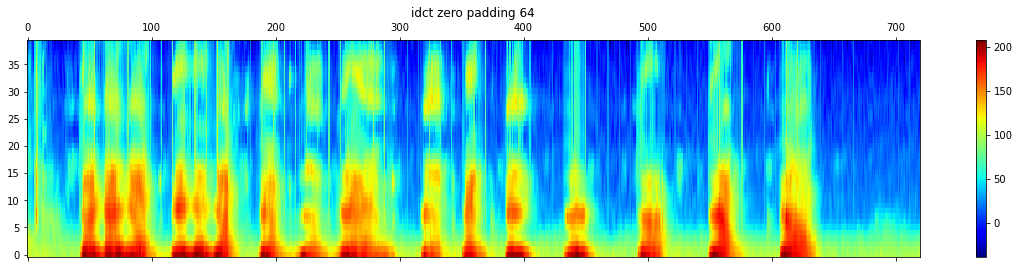

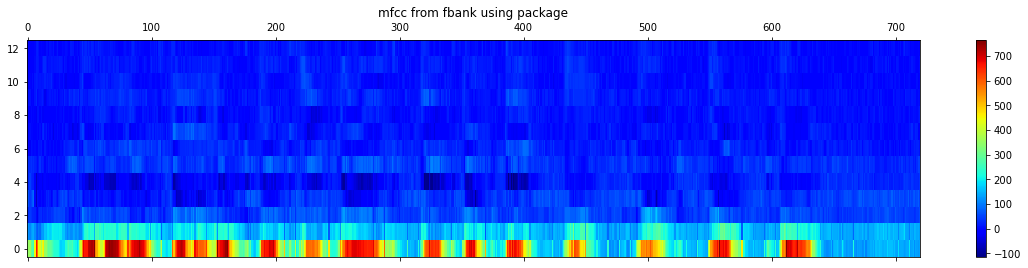

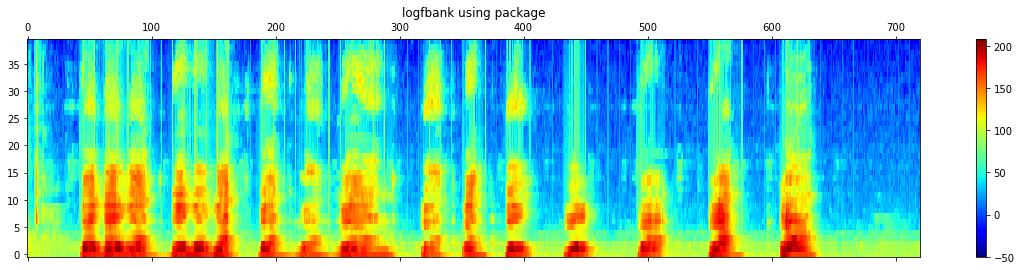

Too long time no one speaking, stop recording!
Audio data saved as Huangrui Chu.wav


In [61]:
rec=Recorder(FORMAT=pyaudio.paInt16, CHANNEL=1, RATE=16000,CHUNK=1600,VAD_setting=setting,Mel_setting=melsetting)
rec.start()